In [ ]:
# Mounting my drive to get dataset;
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data from my google drive and data visualization;
#### took this plant_disease_dataset from Kaggle,
##### link : https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset?resource=download

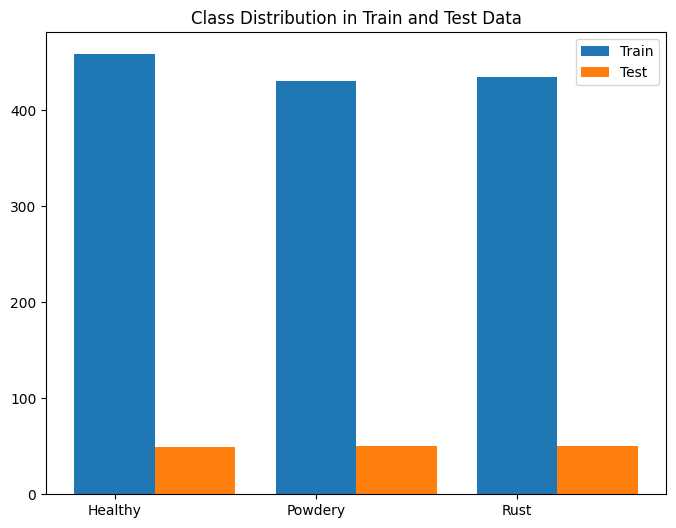

Train :
Number of Healthy : 458
Number of Powdery : 430
Number of Rust : 434
Test :
Number of Healthy : 49
Number of Powdery : 50
Number of Rust : 50


In [ ]:
# Loading required libraries for data visualization;
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Defining the train and test directories;
train_dir = '/content/drive/MyDrive/Plant_dataset/Train'
test_dir = '/content/drive/MyDrive/Plant_dataset/Test'

# Get the class names from the directory names in train_dir;
class_names = (os.listdir(train_dir))

# Counting the number of images in each class in the train and test directories;
train_counts = []
test_counts = []
for class_name in class_names:
    train_path = os.path.join(train_dir, class_name)
    test_path = os.path.join(test_dir, class_name)
    train_counts.append(len(os.listdir(train_path)))
    test_counts.append(len(os.listdir(test_path)))

# Creating a bar plot of the class distributions in the train and test data;
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(train_counts)), train_counts, width=0.4, align='center', label='Train')
ax.bar(np.arange(len(test_counts)) + 0.4, test_counts, width=0.4, align='center', label='Test')
ax.set_xticks(np.arange(len(train_counts)))
ax.set_xticklabels(class_names)
ax.set_title('Class Distribution in Train and Test Data')
ax.legend()
plt.show()

print('Train :')
print(f'Number of Healthy : {[train_counts][0][0]}')
print(f'Number of Powdery : {[train_counts][0][1]}')
print(f'Number of Rust : {[train_counts][0][2]}')

print('Test :')
print(f'Number of Healthy : {[test_counts][0][0]}')
print(f'Number of Powdery : {[test_counts][0][1]}')
print(f'Number of Rust : {[test_counts][0][2]}')

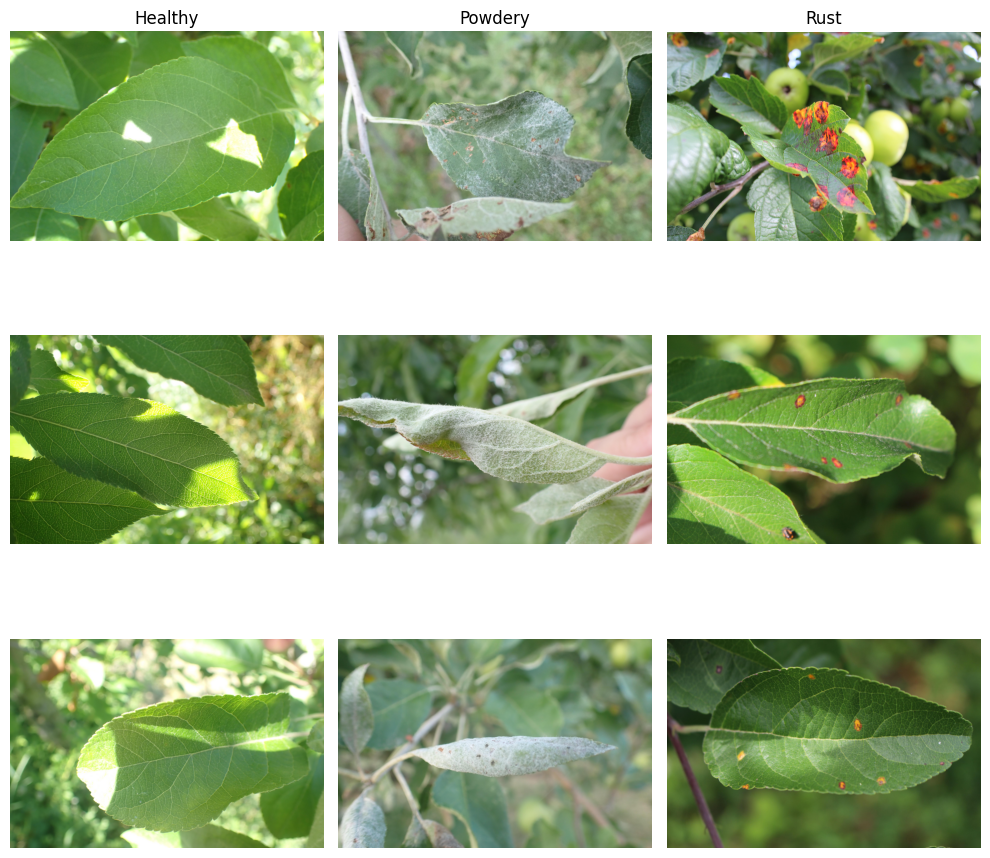

In [ ]:
# Defining a dictionary to store the paths of the images in each class;
image_paths = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_paths[class_name] = [os.path.join(class_path, file) for file in os.listdir(class_path)]

# Displaying three random images from each class;
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, class_name in enumerate(class_names):
    for j in range(3):
        image_path = random.choice(image_paths[class_name])
        image = Image.open(image_path)
        axs[j, i].imshow(image)
        axs[j, i].axis("off")
        if j == 0:
            axs[j, i].set_title(class_name)

plt.tight_layout()
plt.show()


# Training my model leveraging the Transfer Learning technique based on pre-trained EfficientNet model architecture

In [ ]:
# Installing EfficientNet model architecture;
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=a8f77ba547597d2168c56863860a4a17ced03b4621c1ddfbb09b93d2227ae580
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# Importing required libraries;
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib
import torch.optim as optim
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet

In [ ]:
# Set device for GPU if available;
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
## Defining image transforms;
# We define the image transforms required to prepare the train and test images for use as input to the model;

# Transforming train images required to make tensor input for the model;
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transforming test images required to make tensor input for the model;
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Loading dataset from my google drive using the transforms we defined earlier;
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)
class_names = test_dataset.classes
print(class_names)

['Healthy', 'Powdery', 'Rust']


In [ ]:
# Defining dataloaders;
## Generally, we take the batch size of 32-64, taking 32 as a batch size in our case;
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Loading pre-trained EfficientNet B0 model for 3 classes;
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 288MB/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Defining optimizer and loss function;
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:

train_losses = []
train_accs = []
test_losses = []
test_accs = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()  # set the model to train mode;

    # Iterating through the training data;
    for inputs, labels in train_loader:
        print('Labels:',labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # set the gradients to zero;
        outputs = model(inputs)  # forward pass;
        loss = criterion(outputs, labels)  # calculate the loss;
        loss.backward()  # backpropagation
        optimizer.step() # update the weights based on the loss;
        _, preds = torch.max(outputs, 1) # calculate the predicted labels
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(preds == labels.data)
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Iterating through the test data;
    test_loss = 0.0
    test_correct = 0
    model.eval()  # set the model to evaluation mode;
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass;
            loss = criterion(outputs, labels)  # calculate the loss;
            _, preds = torch.max(outputs, 1)  # calculate the predicted labels;
            test_loss += loss.item() * inputs.size(0)
            test_correct += torch.sum(preds == labels.data)
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_correct.double() / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Print the train and test loss and accuracy for each epoch; 
    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

    



Labels: tensor([0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 2,
        0, 1, 2, 2, 2, 2, 0, 2])
Labels: tensor([0, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1,
        1, 2, 2, 1, 2, 0, 2, 0])
Labels: tensor([1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 2, 2, 0,
        1, 1, 1, 0, 1, 1, 1, 0])
Labels: tensor([1, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0,
        2, 2, 0, 2, 2, 0, 2, 2])
Labels: tensor([1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 2, 2, 2, 1])
Labels: tensor([1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 2, 0, 1, 2,
        0, 2, 0, 2, 1, 2, 2, 0])
Labels: tensor([1, 0, 2, 1, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 1,
        2, 2, 2, 2, 1, 1, 0, 1])
Labels: tensor([1, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 1, 1, 2,
        0, 1, 1, 2, 0, 1, 1, 0])
Labels: tensor([2, 0, 0, 0, 1, 2

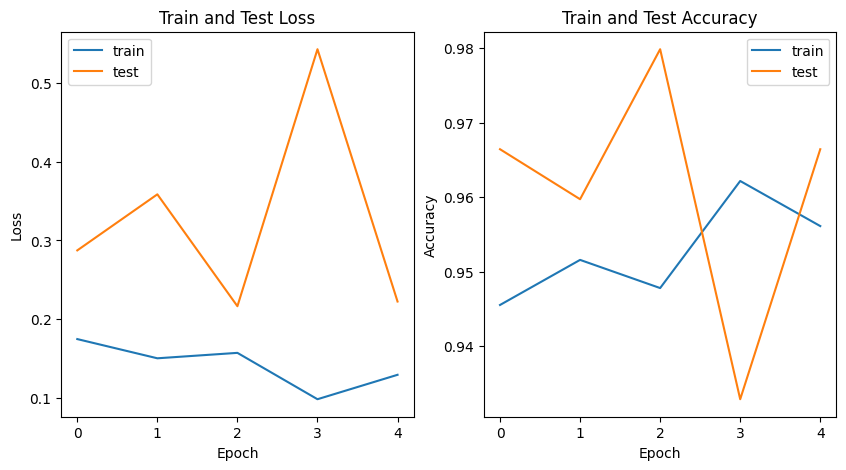

In [ ]:

# Plot the train and test loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.show()


In [ ]:
# Saving the model;
torch.save(model.state_dict(), '/content/model.pth')

# END
